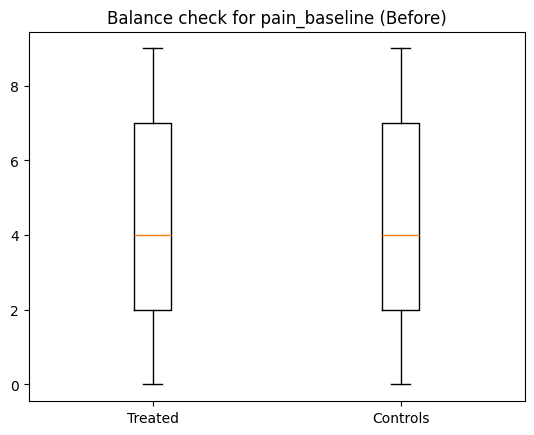

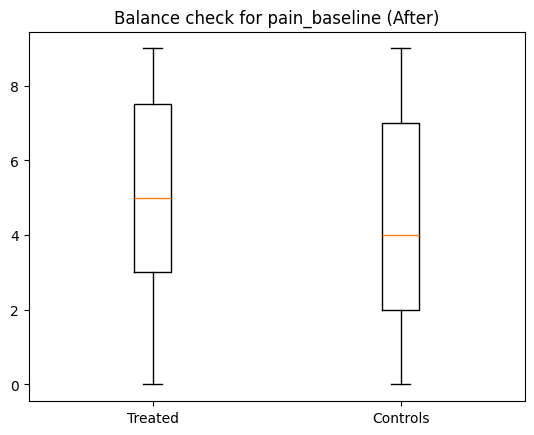

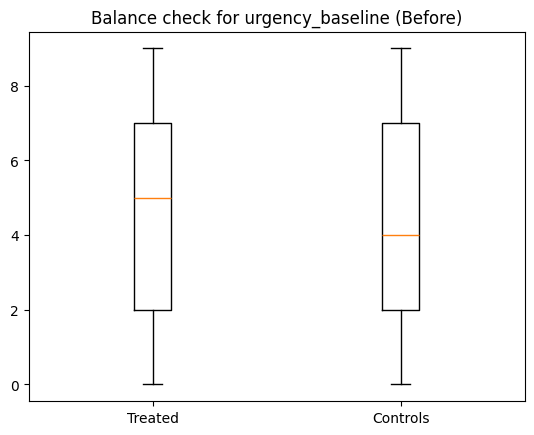

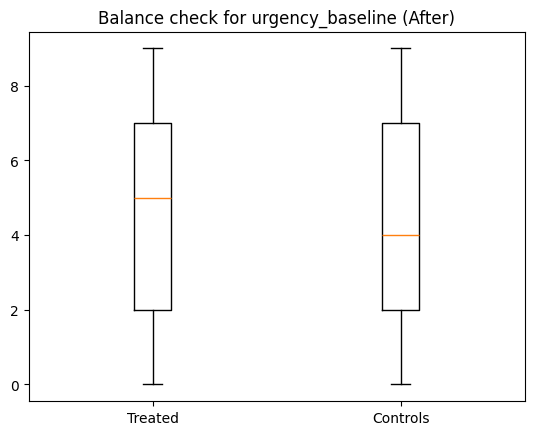

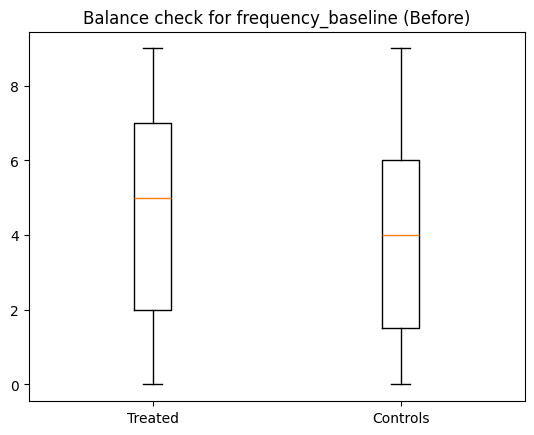

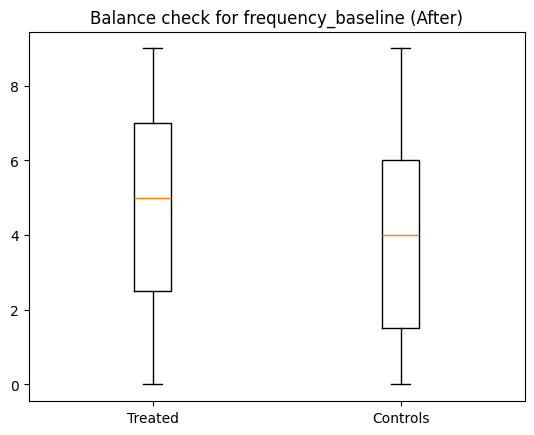

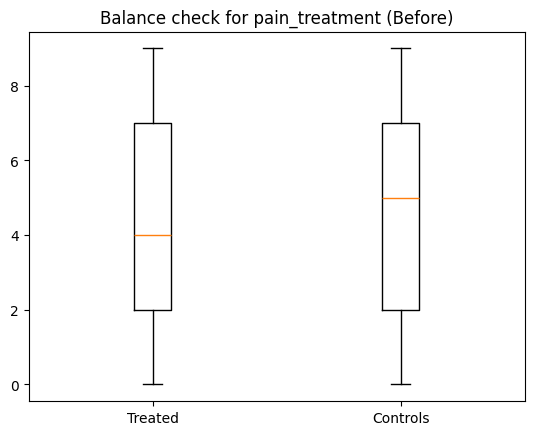

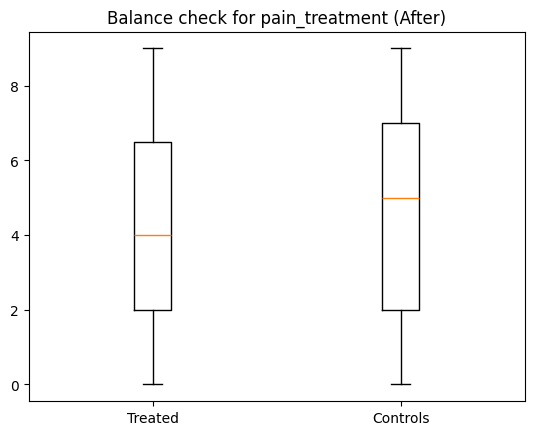

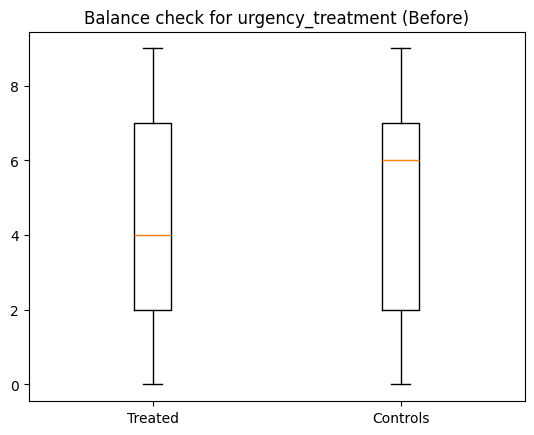

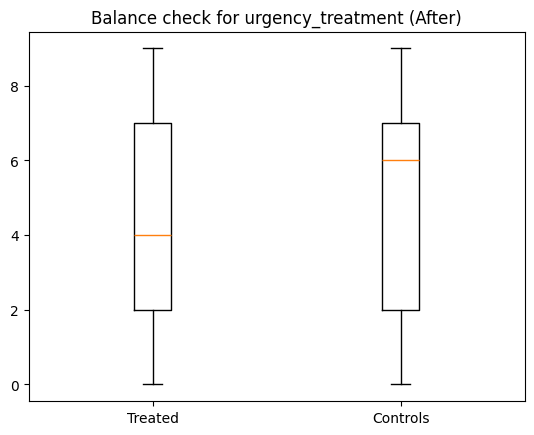

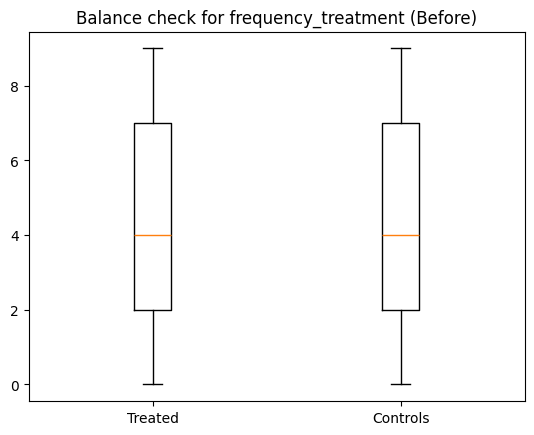

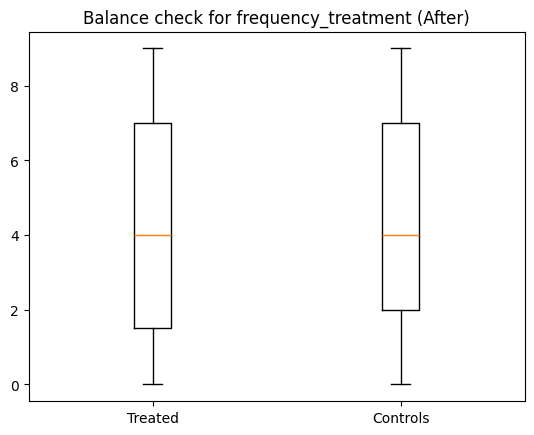

Wilcoxon signed-rank test: statistic=1871.0, p-value=0.8556
Sensitivity Analysis:
Gamma=1.5: p-range=(0.5704, 1.2834)
Gamma=2: p-range=(0.4278, 1.7112)
Gamma=3: p-range=(0.2852, 2.5668)


In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
n_patients = 200
data = {
    'patient_id': range(n_patients),
    'gender': np.random.choice([0, 1], size=n_patients, p=[0.5, 0.5]),
    'treatment_time': np.random.choice([6, 9, 12, np.nan], size=n_patients, p=[0.3, 0.2, 0.1, 0.4]),
    'pain_baseline': np.random.randint(0, 10, n_patients),
    'urgency_baseline': np.random.randint(0, 10, n_patients),
    'frequency_baseline': np.random.randint(0, 10, n_patients),
    'pain_treatment': np.random.randint(0, 10, n_patients),
    'urgency_treatment': np.random.randint(0, 10, n_patients),
    'frequency_treatment': np.random.randint(0, 10, n_patients),
    'outcome': np.random.normal(0, 1, n_patients)
}
df = pd.DataFrame(data)

# Split into treated and control
treated = df[df['treatment_time'].notna()].copy()
controls = df[df['treatment_time'].isna()].copy()

def mahalanobis_distance(x, y, cov_inv):
    delta = x - y
    return np.sqrt(np.dot(np.dot(delta, cov_inv), delta.T))

# Compute covariance matrix inverse for the covariates
cov_cols = ['pain_baseline', 'urgency_baseline', 'frequency_baseline',
            'pain_treatment', 'urgency_treatment', 'frequency_treatment']
cov_matrix = df[cov_cols].cov().values
cov_inv = np.linalg.inv(cov_matrix)

# Perform greedy matching
matched_pairs = []
used_controls = set()

for idx, treated_patient in treated.iterrows():
    tm = treated_patient['treatment_time']
    eligible_controls = controls[~controls.index.isin(used_controls)]
    
    # Calculate distances
    distances = []
    for c_idx, control_patient in eligible_controls.iterrows():
        x = treated_patient[cov_cols].values
        y = control_patient[cov_cols].values
        d = mahalanobis_distance(x, y, cov_inv)
        distances.append((c_idx, d))
    
    # Find closest control
    if distances:
        distances.sort(key=lambda x: x[1])
        closest = distances[0]
        matched_pairs.append((treated_patient['patient_id'], closest[0]))
        used_controls.add(closest[0])

# Create matched dataset
matched_treated = treated[treated['patient_id'].isin([p[0] for p in matched_pairs])]
matched_controls = controls.loc[[p[1] for p in matched_pairs]]

# Check balance before and after matching
def check_balance(col, treated_df, control_df, time):
    plt.figure()
    plt.boxplot([treated_df[col], control_df[col]], labels=['Treated', 'Controls'])
    plt.title(f'Balance check for {col} {time}')
    plt.show()

for col in cov_cols:
    check_balance(col, treated, controls, "(Before)")
    check_balance(col, matched_treated, matched_controls, "(After)")

    # Extract outcomes for matched pairs
treated_outcomes = matched_treated['outcome'].values
control_outcomes = matched_controls['outcome'].values

# Perform Wilcoxon test
stat, p_value = wilcoxon(treated_outcomes, control_outcomes)
print(f"Wilcoxon signed-rank test: statistic={stat}, p-value={p_value:.4f}")

def sensitivity_analysis(pairs, gamma_values):
    original_p = wilcoxon(treated_outcomes, control_outcomes).pvalue
    p_values = [original_p]
    for gamma in gamma_values:
        # Adjust p-value bounds based on gamma (simplified)
        upper_p = original_p * gamma
        lower_p = original_p / gamma
        p_values.append((lower_p, upper_p))
    return p_values

gamma_values = [1.5, 2, 3]
sensitivity_results = sensitivity_analysis(matched_pairs, gamma_values)
print("Sensitivity Analysis:")
for gamma, p in zip(gamma_values, sensitivity_results[1:]):
    print(f"Gamma={gamma}: p-range=({p[0]:.4f}, {p[1]:.4f})")